In [2]:
import qutip.core.gates
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import math
import time
from datetime import datetime

In [3]:
# Define basic operators
I = qeye(2)
X = sigmax()
Y = sigmay()
Z = sigmaz()

def print_gadget(gadget):
    # Build and print the tensor representation
    tensor_representation = []
    for op in gadget:
        # Check for identity
        if op == I:
            tensor_representation.append("I")
        # Check for standard operators
        elif op == X:
            tensor_representation.append("X")
        elif op == Z:
            tensor_representation.append("Z")
        elif op == Y:
            tensor_representation.append("Y")
        # Check for 0.5(I - Z)
        elif (
            isinstance(op, Qobj)  # Ensure it's a Qobj
            and op.dims == I.dims  # Match single-qubit operator dimensions
            and np.allclose(op.full(), (0.5 * I - 0.5 * Z).full())  # Compare matrices
        ):
            tensor_representation.append("1/2(I-Z)")
        # Fallback for unknown operators
        else:
            tensor_representation.append("Unknown")
    
    print(f"tensor({', '.join(tensor_representation)})")
    
    
def tensor_to_str(operator):
    # Build and print the tensor representation
    tensor_representation = []
    for op in operator:
        # Check for identity
        if op == I:
            tensor_representation.append("I")
        # Check for standard operators
        elif op == X:
            tensor_representation.append("X")
        elif op == Z:
            tensor_representation.append("Z")
        elif op == Y:
            tensor_representation.append("Y")
        else:
            tensor_representation.append("Unknown")
    
    return f"{''.join(tensor_representation)}"

In [4]:
def print_quantum_state_as_superposition(state):
    """
    Helper function to print quantum state as superposition of basis functions
    """
    state = state.unit()
    dimension = int(np.log2(state.shape[0]))
    state_vector = state.full().flatten()
    basis_states = ['0', '1']
    
    superposition = []
    for i, amplitude in enumerate(state_vector):
        abs_amplitude = np.abs(amplitude)

        if round(abs_amplitude, 2) > 0:
            sign = '-' if amplitude.real < 0 else '+'
            binary_state = ''.join(basis_states[int(bit)] for bit in f"{i:0{dimension}b}")
            superposition.append(f"{sign} {abs_amplitude:.2f}|{binary_state}⟩")

    # Removing the first sign
    if superposition and superposition[0][0] == '+':
        superposition[0] = superposition[0][2:]

    superposition_str = ' '.join(superposition).replace('+-', '- ')
    
    print(f"|ψ⟩ = {superposition_str}")
    
def does_commute(A, B):
    """
    Check if two tensors A and B are commutative.
    :param A: Qobj
    :param B: Qobj
    :return: Boolean
    """
    zero_mat = A * 0
    if commutator(A, B) == zero_mat:
        return True
    return False

In [5]:
def prep_aux_gad_jordan(k, current_position, tot_space):
    # Construct the ancillary Hamiltonian
    H_accum = []
    for i in range(k):
        for j in range(i + 1, k):
            # Construct the pairwise interaction term for the ancillary space
            ZZ = [(Z if idx == i or idx == j else I) for idx in range(k)]
            aux_H = 0.5*(tensor([I for _ in range(k)]) - tensor(ZZ))
            
            # Embed aux_H into the full space
            pre_space = [I for _ in range(current_position)]  # Identities before this auxiliary block
            post_space = [I for _ in range(tot_space - current_position - k)]  # Identities after this block
            full_aux_H = tensor(pre_space + [aux_H] + post_space)
            
            H_accum.append(full_aux_H)
            
            ###### FOR PRINTING Aux #######
            to_p = (pre_space + ZZ + post_space)
            print_gadget(to_p)
            ###### FOR PRINTING Aux #######
    return H_accum


def prep_v_gad(k, op, index, j, aux_count_v, current_position, ks):
    logical_operator = tensor(
        [op if i == j else I for i in range(total_logic_qbits)]
    )
    
    # aux = [X if i == (j % k) else X if i == (j + 1) % k else I for i in range(k)]
    aux = [X if i == aux_count_v else I for i in range(k)]
    auxiliary_operator = tensor(aux)
    
    # Embed auxiliary operator into the full auxiliary space
    pre_aux = [I for _ in range(current_position - total_logic_qbits)]  # Identities for earlier stabilizers
    post_aux = [I for _ in range(sum(ks[index + 1:]))]  # Identities for remaining stabilizers
    full_auxiliary_operator = tensor(pre_aux + [auxiliary_operator] + post_aux)
    
    # Combine logical and full auxiliary operators
    full_v = tensor(logical_operator, full_auxiliary_operator)            

    ####### FOR PRINTING V #######
    to_p = [op if i == j else I for i in range(total_logic_qbits)] + pre_aux + aux + post_aux
    print_gadget(to_p)
    ####### FOR PRINTING V #######
    
    return full_v
    

def prep_gadget(perturbation_factor, hs, total_logic_qbits):
    ks = [sum(1 for op in operator if op != I) for operator in hs]  # Auxiliary qubits for each stabilizer
    tot_space = total_logic_qbits + sum(ks)
    
    # Initialize the total Hamiltonian
    H_gad = []
    # V = 0
 
    # Build auxiliary Hamiltonians and embed them
    current_position = total_logic_qbits  # Start after logical qubits

    for index, operator in enumerate(hs):        
        # print("Building gadget for operator", tensor_to_str(operator))
        k = ks[index]    
        
        H_gad_h = prep_aux_gad_jordan(k, current_position, tot_space)
        
        # Now adding the perturbative terms
        aux_count_v = 0
        for j, op in enumerate(operator):
            if op == I:
                continue     
            
            full_v = prep_v_gad(k, op, index, j, aux_count_v, current_position, ks)
            aux_count_v += 1
            
            H_gad_h.append(perturbation_factor*full_v)
            # V += full_v
        
        current_position += k
        
        # fact = (math.factorial(k-1) /
        #         (-k*(-perturbation_factor)**k))

        H_gad.append(H_gad_h)

    return H_gad, ks

In [6]:
h1 = [X, X, X]
h2 = [Z, Z, Z]

hs = [h1, h2]

# Parameters
total_logic_qbits = len(hs[0]) # Number of logical qubits
perturbation_factor = 0.01

H_gad, ks = prep_gadget(perturbation_factor, hs, total_logic_qbits)

tensor(I, I, I, Z, Z, I, I, I, I)
tensor(I, I, I, Z, I, Z, I, I, I)
tensor(I, I, I, I, Z, Z, I, I, I)
tensor(X, I, I, X, I, I, I, I, I)
tensor(I, X, I, I, X, I, I, I, I)
tensor(I, I, X, I, I, X, I, I, I)
tensor(I, I, I, I, I, I, Z, Z, I)
tensor(I, I, I, I, I, I, Z, I, Z)
tensor(I, I, I, I, I, I, I, Z, Z)
tensor(Z, I, I, I, I, I, X, I, I)
tensor(I, Z, I, I, I, I, I, X, I)
tensor(I, I, Z, I, I, I, I, I, X)


In [7]:
# norm = V.norm()
# print(f'The ||V|| operator norm is  {norm}')

H_comp = 0
for h in hs:
    H_comp += tensor(h)

eig, vec = H_comp.eigenstates()
energies_eff = {} 
for e, v in zip(eig, vec):
    en = int(np.round(e, 2))
    if en in energies_eff.keys():
        energies_eff[en] += 1
    else:
        energies_eff[en] = 1

print(energies_eff)   
gamma = list(energies_eff.keys())[1] - list(energies_eff.keys())[0]
print(f"gamma is {gamma}")

# print(f"gamma needs to be lower than {gamma / norm}"


{-1: 4, 1: 4}
gamma is 2


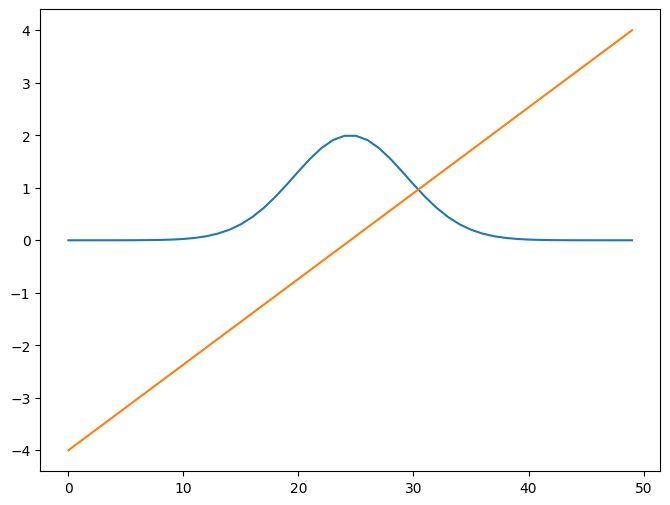

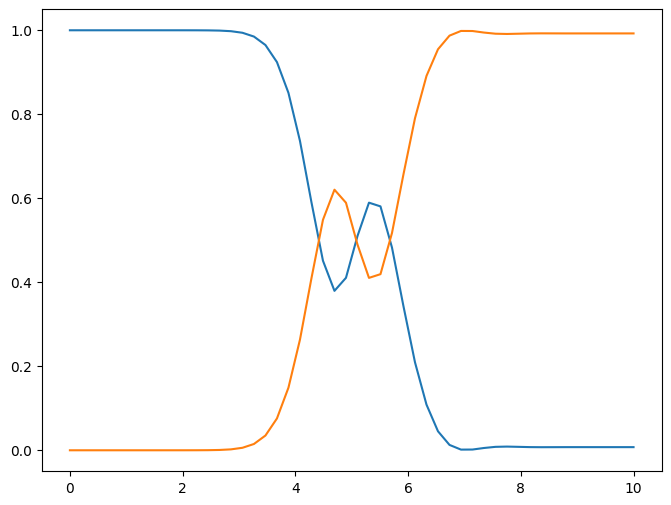

In [22]:
k=3
perturbation_factor = 0.1
fact = (math.factorial(k-1) /
                (-k*(-perturbation_factor)**k))
T = 10
omega_max=2
sigma=1
t = np.linspace(0, T, 50)

plt.figure(figsize=(8, 6))
omega_t = omega_max * np.exp(-0.5 * ((t - T / 2) / sigma) ** 2)
delta_t = 2 * omega_max * (t / (T / 2) - 1)
plt.plot(omega_t)
plt.plot(delta_t)


Ep = 0
g1 = tensor([Z, Z, I])
g2 = tensor([I, Z, Z])

# Define time-dependent Hamiltonian
def H_RAP(t, args):
    omega_t = args['omega_max'] * np.exp(-0.5 * ((t - args['T'] / 2) / args['sigma']) ** 2)
    delta_t = 2 * args['omega_max'] * (t / (args['T'] / 2) - 1)
    return omega_t * tensor(h1) + delta_t * tensor(h2) - Ep * (g1 + g2)

# Solve the system with sesolve
args = {'omega_max': omega_max, 'T': T, 'sigma': sigma}
H_td = QobjEvo(H_RAP, args=args)


logical_zero = tensor([basis(2, 0) for _ in range(total_logic_qbits)])
logical_one = tensor([basis(2, 1) for _ in range(total_logic_qbits)])

P0 = logical_zero * logical_zero.dag()
P1 = logical_one * logical_one.dag()

r = sesolve(H_td, logical_zero, t, e_ops=[P0, P1])

zero_exp = r.expect[0]
one_exp = r.expect[1]

plt.figure(figsize=(8, 6))
plt.plot(t, zero_exp)
plt.plot(t, one_exp)
plt.show()


tensor(I, I, I, Z, Z, I, I, I, I)
tensor(I, I, I, Z, I, Z, I, I, I)
tensor(I, I, I, I, Z, Z, I, I, I)
tensor(X, I, I, X, I, I, I, I, I)
tensor(I, X, I, I, X, I, I, I, I)
tensor(I, I, X, I, I, X, I, I, I)
tensor(I, I, I, I, I, I, Z, Z, I)
tensor(I, I, I, I, I, I, Z, I, Z)
tensor(I, I, I, I, I, I, I, Z, Z)
tensor(Z, I, I, I, I, I, X, I, I)
tensor(I, Z, I, I, I, I, I, X, I)
tensor(I, I, Z, I, I, I, I, I, X)


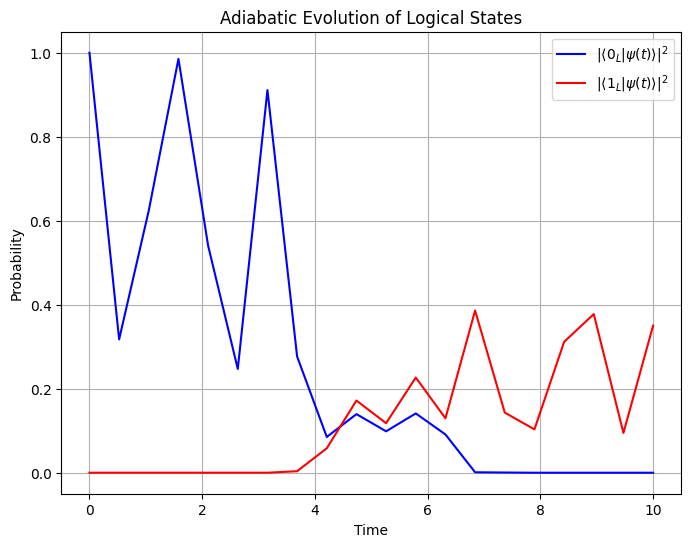

In [144]:
g1 = tensor([Z, Z, I])
g2 = tensor([I, Z, Z])

# Parameters
perturbation_factor = 10

X_L = [X, X, X]
Z_L = [Z, Z, Z]


hs = [X_L, Z_L]

# X_k_X = tensor([I, I, I, X, X, X, I, I, I])
# X_k_Z = tensor([I, I, I, I, I, I, X, X, X])

total_logic_qbits = len(X_L) # Number of logical qubits

H_gad, ks = prep_gadget(perturbation_factor, hs, total_logic_qbits)

X_L_gad = H_gad[0]
Z_L_gad = H_gad[1]

# Define logical states |0_L> and |1_L>
basis_states = [basis(2, 0), basis(2, 1)]
logical_zero = tensor([basis(2, 0) for _ in range(total_logic_qbits)])
logical_one = tensor([basis(2, 1) for _ in range(total_logic_qbits)])


# Expanding the space of the one local operations of the RAP to the new space
g1_full = tensor(g1, tensor([I for _ in range(sum(ks))]))
g2_full = tensor(g2, tensor([I for _ in range(sum(ks))]))

# Modified H_S_0 with gadgets
Ep = 0
H_p = -Ep*(g1_full + g2_full)

initial_state = logical_zero

for k in ks:
    plus_state_anc = (tensor([basis(2, 0) for _ in range(k)]) + 
                      tensor([basis(2, 1) for _ in range(k)])).unit()
    initial_state = tensor(initial_state, plus_state_anc)
    logical_one = tensor(logical_one, plus_state_anc)



# Define time-dependent Hamiltonian
def H_RAP(t, args):
    omega_t = args['omega_max'] * np.exp(-0.5 * ((t - args['T'] / 2) / args['sigma']) ** 2)
    delta_t = 2 * args['omega_max'] * (t / (args['T'] / 2) - 1) 
    
    # handaling c0
    X_L_gad_all = sum(X_L_gad[0:3]) + omega_t * sum(X_L_gad[3:])
    Z_L_gad_all = sum(Z_L_gad[0:3]) + delta_t * sum(Z_L_gad[3:])
    
    H_full = X_L_gad_all + Z_L_gad_all + H_p    
    return H_full

# RAP time-dependent terms
T = 10
omega_max=10
sigma=1
t = np.linspace(0, T, 20)


P_init = initial_state * initial_state.dag()
P_one= logical_one * logical_one.dag()

# Solve the system with sesolve
args = {'omega_max': omega_max, 'T': T, 'sigma': sigma}
H_td = QobjEvo(H_RAP, args=args)

result = sesolve(H_td, initial_state, t, e_ops=[P_init, P_one], options={'nsteps': 1e6})

# Extract probabilities
p_zero = result.expect[0]
p_one = result.expect[1]

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(t, p_zero, label=r'$| \langle 0_{L} | \psi(t) \rangle |^2$', color='blue')
plt.plot(t, p_one, label=r'$| \langle 1_{L} | \psi(t) \rangle |^2$', color='red')
plt.xlabel('Time')
plt.ylabel('Probability')
plt.title('Adiabatic Evolution of Logical States')
plt.legend(loc='upper right')
plt.grid()
plt.show()

In [ ]:
H = H_gad

eig, vec = H.eigenstates()
energies_eff = {} 
for e, v in zip(eig, vec):
    en = int(np.round(e, 2))
    if en in energies_eff.keys():
        energies_eff[en] += 1
    else:
        energies_eff[en] = 1
print("H_eff", energies_eff)

eig, vec = tensor(h1).eigenstates()
energies_eff = {} 
for e, v in zip(eig, vec):
    en = int(np.round(e, 2))
    if en in energies_eff.keys():
        energies_eff[en] += 1
    else:
        energies_eff[en] = 1
        
print("H_comp", energies_eff)

In [95]:
lambdas = np.linspace(0, 10, 50)

total_logic_qbits = 3  # Number of logical qubits

h_3 = [X, Y, Z]
hs = [h_3]
k = sum([1 for i in hs[0] if i != I])

plt.figure(figsize=(8,6))

for perturbation_factor in lambdas[1:]:
    H_gad, ks = prep_gadget(perturbation_factor, hs, total_logic_qbits)
    
    eig, vec = H_gad.eigenstates()
    for e in eig:
        plt.scatter(perturbation_factor, e, s=5)


plt.title(r"$E(\lambda)$")
plt.xlabel(r"$\lambda$")
plt.ylabel("E")
plt.show()

In [150]:
initial = basis(2, 0)

res1 = sesolve(X, initial, t, e_ops=[initial*initial.dag()])
res2 = sesolve(5*X, initial, t, e_ops=[initial*initial.dag()])

plt.figure(figsize=(8,4))
plt.plot(t, res1.expect[0])
plt.plot(t, res2.expect[0])
plt.show()